In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from fastai import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import torch 
from torch import nn
from torch.nn import functional as F

In [4]:
PATH='../../../cat-dogs-data-np/'
sz=224
arch=resnet34
bs=64

In [5]:
m=arch(pretrained=True)

In [8]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [30]:
m=nn.Sequential(*list(m.children())[:-2],
                nn.Conv2d(512,2,3,padding=1),
                nn.AdaptiveAvgPool2d(1),Flatten(),
                nn.LogSoftmax())

In [32]:
trfm=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
data=ImageClassifierData.from_paths(PATH,bs,tfms=trfm)

In [34]:
learn=ConvLearner.from_model_data(m,data)

In [37]:
learn.freeze_to(-4)

In [39]:
learn.fit(0.01,1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.174934   0.375357   0.984833  



[array([0.37536]), 0.9848331648129424]

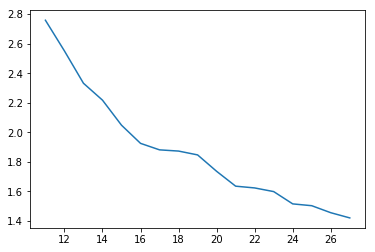

In [100]:
learn.sched.plot_loss()

In [40]:
class SaveFeature():
    def __init__(self,m):
        self.hook=m.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.feature=to_np(output)
    def remove(self):
        self.hook.remove()

In [47]:
x,y=next(iter(data.val_dl))
x,y=x[None,1],y[None,1]
vx=Variable(x,requires_grad=True)

In [90]:
im=data.val_ds.denorm(x)[0]

In [59]:
sf=SaveFeature(learn[-4])
py=m(Variable(x))
sf.remove()

In [78]:
py=np.exp(to_np(py))

In [80]:
feat=np.maximum(0,sf.feature[0])
feat.shape

(2, 7, 7)

In [83]:
f2=feat[py.argmax()]

In [88]:
f2-=f2.min()
f2/=f2.max()

In [89]:
f2

array([[0.04898, 0.08636, 0.09887, 0.16954, 0.31925, 0.39802, 0.27545],
       [0.0828 , 0.14968, 0.19754, 0.3383 , 0.61154, 0.77924, 0.56685],
       [0.08344, 0.17782, 0.27231, 0.46712, 0.80082, 1.     , 0.72837],
       [0.09592, 0.20916, 0.3307 , 0.52857, 0.83773, 0.99745, 0.7087 ],
       [0.10133, 0.22163, 0.33239, 0.48373, 0.68483, 0.73354, 0.48714],
       [0.06741, 0.15755, 0.23206, 0.31134, 0.39362, 0.36551, 0.20982],
       [0.     , 0.04099, 0.07108, 0.10156, 0.11933, 0.0827 , 0.01486]], dtype=float32)

In [91]:
im.shape

(224, 224, 3)

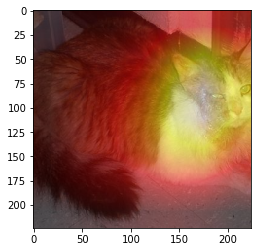

In [95]:
plt.imshow(im)
plt.imshow(cv2.resize(f2,(224,224)),alpha=0.5,cmap='hot')